In [ ]:
import getpass
from typing import List, Optional, TypedDict, Any
from typing_extensions import Annotated
from operator import or_
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import Image, display
import logging

# === Logging Configuration ===
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Set the root logger level to INFO

# Remove all handlers associated with the root logger object.
if logger.hasHandlers():
    logger.handlers.clear()

# Create a new handler
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)  # Set handler level to INFO

# Create a formatter and set it for the handler
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Add the handler to the root logger
logger.addHandler(handler)
# === End of Logging Configuration ===

def first_non_null(a, b):
    return a if a is not None else b

In [44]:
FIRECRAWL_API_KEY = getpass.getpass("Firecrawl API Key: ")


In [45]:
from typing import Sequence
from langchain_core.messages import AnyMessage , BaseMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from typing import Literal

In [ ]:
import operator

class InputState(TypedDict):
    url: str
    keyword: str
    messages: Annotated[Sequence[BaseMessage], add_messages]

class OverallState(TypedDict):
    urls:Annotated[list, operator.add]
    curr_url_index:int
    total_urls:int
    urls_to_scrape:List[str]
    extracted_info : Annotated[List[str], add_messages]
    extracted_from_url:Annotated[List[str],add_messages]
    is_information_found:Annotated[Optional[bool],or_]
    keyword:str
    final_ans=str
    messages: Annotated[Sequence[BaseMessage], add_messages]
    
class new_input_state(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [47]:
from langchain_core.messages import HumanMessage
def llm_decision(state:new_input_state)->InputState:

    class Decision(BaseModel):
        requires_scraping: bool
        reasoning: str
        url: Optional[str] = None
        keyword: Optional[str] = None
    
    prompt = PromptTemplate(
        template="""You are an AI assistant that analyzes user questions to determine whether they require web scraping or can be answered with general knowledge.

Your role is to analyze the *nature of the question* and determine if answering it accurately would require scraping a website or accessing live content on the web.

Note: You are not performing scraping yourself — only classifying whether scraping is needed.

Analyze the following user question and determine if it requires web scraping:

USER QUESTION: {question}

DECISION CRITERIA:
1. REQUIRES SCRAPING if the question:
   - Asks for current/live information from a specific website
   - Requests real-time data, prices, availability, or status
   - Asks about specific content on a particular webpage
   - Seeks information that changes frequently (prices, stock, weather, news, etc.)
   - Mentions specific URLs or websites to check
   - Asks for "latest" or "current" information from the web
   - Requests to "check", "look up", or "find" something on a website
   - Asks about specific products, services, restaurant info, or listings on websites
   - Contains words like "check", "find", "look up", "current", "latest", "price", "availability", "status", "open now", "trending", etc.
   - Relies on user-location-based or time-sensitive data (e.g. restaurant hours, event schedules, delivery options)

2. DOES NOT REQUIRE SCRAPING if the question:
   - Asks for general knowledge, explanations, or definitions
   - Requests historical information or factual data
   - Asks for opinions, advice, or recommendations that do not depend on real-time content
   - Seeks help with coding, logic, math, writing, or conceptual analysis
   - Asks for explanations of terms, workflows, or processes
   - Is conversational or philosophical in nature
   - Asks about generally known or widely available non-dynamic content
   - Contains phrases like "what is", "how to", "explain", "define", "describe", "why does", "benefits of", "steps to", etc.

EXAMPLES:
- "What's the weather like today?" → REQUIRES SCRAPING (current weather data)
- "What is machine learning?" → NO SCRAPING (general knowledge)
- "Check the price of iPhone on Amazon" → REQUIRES SCRAPING (current prices)
- "How do I cook pasta?" → NO SCRAPING (general knowledge)
- "What's the latest news about AI?" → REQUIRES SCRAPING (current news)
- "Explain quantum physics" → NO SCRAPING (general knowledge)
- "Check if this website has information about Python" → REQUIRES SCRAPING (website content)
- "What are the benefits of exercise?" → NO SCRAPING (general knowledge)
- "Find information about React on MDN" → REQUIRES SCRAPING (specific website content)
- "What is the capital of France?" → NO SCRAPING (general knowledge)
- "Check the stock price of Apple" → REQUIRES SCRAPING (real-time data)
- "What is the meaning of life?" → NO SCRAPING (philosophical question)

Based on your analysis, provide:
1. requires_scraping: true/false  
2. reasoning: brief explanation of your decision  
3. url: if scraping is needed, extract the URL from the question or suggest a relevant one  
4. keyword: if scraping is needed, identify the key search term or topic to look for

Your response should be structured and logical.
""",
        input_variables=["question"],
    )
    
    llm = ChatGroq(model="qwen/qwen3-32b")
    model = llm.with_structured_output(Decision)
    chain = prompt | model
    if not state.get('messages') or len(state['messages']) == 0:
        logging.error("No messages found in state!")
        return {"url": None, "keyword": None}
    question = state['messages'][0].content
    
    try:
        result = chain.invoke({"question": question})
        
        if result.requires_scraping:
            # Return state for scraping workflow
            return {
                "url": result.url or "https://www.google.com",  # Default fallback
                "keyword": result.keyword or "information",
                "messages": [HumanMessage(content=question)]
            }
        else:
            # Return state for general response (you might want to route to a different node)
            return {
                "url": None,
                "keyword": None,
                "messages":[HumanMessage(content=question)]
            }
    except Exception as e:
        logging.error(f"Error in llm_decision: {e}")
        # Default to general response on error
        return {
            "url": None,
            "keyword": None,
            "messages":[HumanMessage(content=question)]
        }
    
def route_decision(state: InputState) -> Literal['first_node','general_response']:
    """
    Routes the decision to either scraping workflow or general response.
    
    Args:
        state: Dictionary containing the result from llm_decision
        
    Returns:
        String indicating the next node to execute
    """
    logging.info("Executing route_decision function")
    
    # Check if we have URL and keyword for scraping
    if state.get('url') and state.get('keyword'):
        logging.info(f"Routing to scraping workflow with URL: {state['url']} and keyword: {state['keyword']}")
        return "first_node"
    else:
        logging.info("Routing to general response - no scraping required")
        return "general_response"

def general_response(state:new_input_state):
    pass

In [48]:
def first_node(state: InputState) -> OverallState:
    logging.info("Executing node: first_node")
    return {
        "urls": [state["url"]],
        "curr_url_index": 0,
        "total_urls": 0,
        "urls_to_scrape": [],
        "keyword": state["keyword"],
        "extracted_info": [],
        "extracted_from_url": [],
        "is_information_found": False,
        "final_ans":"",
        "messages":state["messages"]
    }

In [49]:
from firecrawl import FirecrawlApp

In [50]:
all_urls=[]

In [ ]:
def get_sitemap(state:OverallState,config)-> OverallState:
    logging.info("Executing node: get_sitemap")
    api_key=config.get("configurable",{}).get("firecrawl_api_key","")
    if not api_key:
        logging.error("Firecrawl API key is missing in the configuration")
        raise ValueError("Firecrawl API key is missing in the configuration")
    
    app = FirecrawlApp(api_key=api_key)
    map_result = app.map_url(url=state['urls'][0],search=state['keyword'])
    logging.info(f"map_result is here: {map_result}")

    if(map_result):
        if map_result.success and map_result.links:
            # isinstnce only checks the objects data type not its value,,even if we have empty list but it must be list if we want isinstance to return true
            sitemap = map_result.links
            state['urls']=sitemap
            state['total_urls']=len(sitemap)
            logging.info(f"total url found to scrape {len(sitemap)}")
        
        else:
            logging.error(f"Error: Invalid response structure in map_result: {map_result}")
            state["urls"] = []
    else:
        logging.error(f"Error: Unexpected format in map_result(we require dict): {map_result}")
        state["urls"] = []

    return state

In [ ]:
def scrape_manager(state:OverallState):
    logging.info("Executing Node: scrape_manager")
    total_urls = state.get('total_urls',0)
    current_index = state.get('curr_url_index',0)
    new_index = min(current_index+3,total_urls)
    urls_to_scrape = state['urls'][current_index:new_index]
    state['curr_url_index'] = new_index
    state['urls_to_scrape'] = urls_to_scrape
    
    if(total_urls==0):
        logging.info("No urls to scrape from the website")
    return state


In [53]:
my_answer=[]

In [54]:
my_answer

[]

In [ ]:
def scraper(state:OverallState , config)->OverallState:
    url = state['urls']
    keyword = state['keyword']
    to_scrape = state['urls_to_scrape']
    logging.info(f"Executing node: scraper for URL: {url}")
    api_key = config.get('configurable',{}).get('firecrawl_api_key','')
    if not api_key:
        logging.error("Firecrawl API key is missing in the configuration")
        raise ValueError("Firecrawl API key is missing in the configuration")
    
    app = FirecrawlApp(api_key=api_key)
    extracted_info = []
    extracted_from_url = []
    is_information_found = False
    scrape_result={}
    for i in to_scrape:
        try:
            logging.info(f"Started Scrapping of : {i}")
            scrape_result = app.scrape_url(i,formats=['markdown'])
            if scrape_result:
                markdown_content = scrape_result.markdown
                my_answer.append(markdown_content) 
                # logging.info(f"scrape_result : {markdown_content}")
                extracted_info.append(markdown_content)
                extracted_from_url.append(i)
                is_information_found = True
                # Append to the global list immediately upon finding the keyword
                # If you want to stop scraping the current batch once found, uncomment break
                # break 
            else:
                logging.warning(f"Failed to scrape url {i}")        
            # if scrape_result:
            #     list_of_content.append(scrape_result)
            logging.info(f"Scrapping Done of : {i}")

        except Exception as e:
            logging.info(f"Error occured while scraping {i} , Error {e}")
            # scrape_result={}
    return {
        "extracted_info": extracted_info,  # This will be accumulated by the reducer
        "extracted_from_url": extracted_from_url,
        "is_information_found": is_information_found,
    }

In [56]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.messages import AIMessage
from langchain.tools.retriever import create_retriever_tool
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import FAISS

def evaluate(state: OverallState):
    logging.info("Execuring Node: evaluate")
    return state

# cnt=0


def evaluate_routing(state: OverallState):
    if(state['curr_url_index']==state['total_urls']):
        logging.info(f"URLs are processed completely..")
        return 'generate_ans'
    
    if (state["curr_url_index"] >= 6):
        logging.info(f"stop krna pdaaa")
        logging.info(
            f"extracted_url looks like \n {state['extracted_from_url']}")
        return "generate_ans"
    # elif(state.get('is_information_found',False)):
    #     logging.info(f"Information found in url : {state.get('extracted_from_url')}")
    #     logging.info("terminating graph execution")
    #     return "END"

    elif state["curr_url_index"] < len(state["urls"]):
        # cnt=cnt+1
        # if(cnt==4):
        #     return "END"

        logging.info(
            f"Scrapping further urls till now {state['curr_url_index']+1} urls are scrapped.")
        return "scrape_manager"

    else:
        logging.info("No more URLs to scrape, terminating graph execution.")
        return "generate_ans"


def generate_ans(state: OverallState) -> dict:
    user_question = state["messages"][0].content
    extracted_info = state.get("extracted_info", [])
    llm = ChatGroq(model="llama-3.3-70b-versatile")  # or your preferred LLM

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000, chunk_overlap=100)
    embeddings = OllamaEmbeddings(model="nomic-embed-text:v1.5")
    all_chunks = []

    for markdown in extracted_info:
        markdown_str = markdown.content if hasattr(
            markdown, "content") else str(markdown)
        doc = Document(page_content=markdown_str)
        chunks = splitter.split_documents([doc])

        all_chunks.extend(chunks)


    vector_store = FAISS.from_documents(all_chunks, embedding=embeddings)

    relevant_docs = vector_store.similarity_search(
        user_question, k=5)  # k = number of top docs to retrieve

    context = "\n\n".join(doc.page_content for doc in relevant_docs)
    prompt = PromptTemplate(
        template=(
            "You are an expert assistant. Use the following context to answer the user's question in a well-structured format.\n\n"
            "Context:\n"
            "{context}\n\n"
            "Question:\n"
            "{question}\n\n"
        ),
        input_variables=["context", "question"],
    )

    chain = prompt | llm

    answer = chain.invoke({"context": context, "question": user_question})

    logging.info(f"final answer : {answer}")


    return {'messages': [AIMessage(content=answer.content if hasattr(answer, 'content') else str(answer))]}

C:\Users\Lakshay\AppData\Local\Temp\ipykernel_21300\1008868736.py:4: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(OverallState,input=new_input_state,config_schema=ConfigSchema)


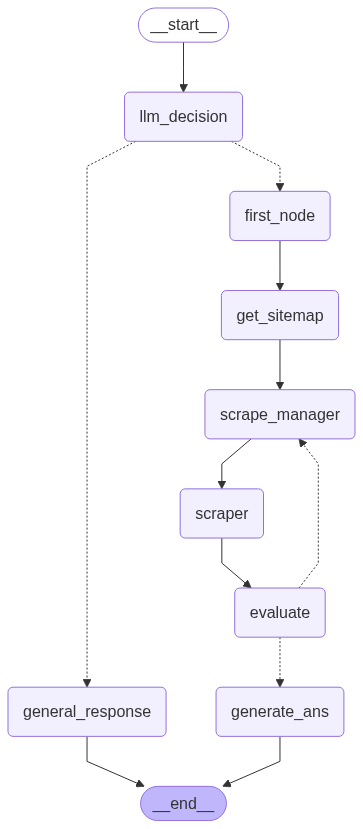

In [57]:
class ConfigSchema(TypedDict):
    firecrawl_api_key:str

builder = StateGraph(OverallState,input=new_input_state,config_schema=ConfigSchema)


builder.add_node("llm_decision",llm_decision)
builder.add_node("general_response", general_response)
builder.add_node("first_node",first_node)
builder.add_node("get_sitemap",get_sitemap)
builder.add_node("scrape_manager",scrape_manager)
builder.add_node("scraper",scraper)
builder.add_node("evaluate",evaluate)
builder.add_node("generate_ans", generate_ans)

builder.add_edge(START,'llm_decision')
builder.add_conditional_edges(
    'llm_decision',
    route_decision,
    {
        "general_response":"general_response","first_node":"first_node"
    }
)
builder.add_edge('general_response',END)
builder.add_edge('first_node','get_sitemap')
builder.add_edge('get_sitemap','scrape_manager')
builder.add_edge('scrape_manager','scraper')
# builder.add_conditional_edges(
#     'scrape_manager',
#     continue_to_scraper,
#     ["scraper"]
# )
builder.add_edge('scraper','evaluate')
builder.add_conditional_edges(
    'evaluate',
    evaluate_routing,
    {
        "generate_ans":"generate_ans","scrape_manager":"scrape_manager"
    }
)
builder.add_edge("generate_ans", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
config = {"configurable": {"firecrawl_api_key": FIRECRAWL_API_KEY}, "recursion_limit": 50}

# input_state = {
#     "url": "https://www.airbnb.co.in/rooms/1041023648875338069?search_mode=regular_search&adults=1&check_in=2025-07-18&check_out=2025-07-20&children=0&infants=0&pets=0&source_impression_id=p3_1752255384_P3xMAycXE07omYGL&previous_page_section_name=1000&federated_search_id=3d088a69-e4b1-4915-91e9-a39bf2b7d30f",
#     "keyword": "Frontend"
# }

# result = graph.invoke(input_state, config=config)
from langchain_core.messages import HumanMessage

user_question = "I am planning trip to Goa suggest the hotels name along with prices"
input_state = {
    "messages": [HumanMessage(content=user_question)]
}

result = graph.invoke(input_state, config=config)

2025-07-16 01:39:53,040 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 01:39:53,044 - INFO - Executing route_decision function
2025-07-16 01:39:53,046 - INFO - Routing to scraping workflow with URL: https://www.booking.com and keyword: hotels in Goa price
2025-07-16 01:39:53,047 - INFO - Executing node: first_node
2025-07-16 01:39:53,049 - INFO - Executing node: get_sitemap
2025-07-16 01:40:07,226 - INFO - map_result is here: success=True links=['https://www.booking.com/hotel/pl/villa-julia-miedzyzdroje.html?label=gen173nr-1BCAsotgFCGHZpbGxhLWp1bGlhLW1pZWR6eXpkcm9qZUgeWARolQKIAQGYATG4ARnIAQzYAQHoAQGIAgGoAgO4AqLBscMGwAIB0gIkNDliYTVmMTAtYzYzYi00ZTU5LThjZWUtYTcyYzZlNmMyNjRl2AIF4AIB&sid=77e58aa2fb40c4992dc28f2d42ef9af0&dist=0&keep_landing=1&sb_price_type=total&type=total&', 'https://www.booking.com/hotel/pl/villa-magnat-bialka-tatrzanska.html?label=gen173nr-1BCAsotgFCHnZpbGxhLW1hZ25hdC1iaWFsa2EtdGF0cnphbnNrYUgeWARolQKIAQGYATG4ARnIAQ

In [59]:
'The price of the Nike Air 2 Retro Low Tex Sneakers in India is:\n\n**₹4,322**\n\nThis is a special price, which is 34% off the original price of **₹6,599**.'

'The price of the Nike Air 2 Retro Low Tex Sneakers in India is:\n\n**₹4,322**\n\nThis is a special price, which is 34% off the original price of **₹6,599**.'